# Dimensionality Reduction: A Single-Cell Example
Author: Sebastian Rauschert for INSiGENe

To set up your compute environment to work for this notebook, install `conda` and then run the following on your terminal:

```
conda create -n scanpy_env python=3.10
conda activate scanpy_env
conda install -c conda-forge -c bioconda scanpy python-igraph leidenalg matplotlib numpy
```

## A Beginner's Guide to PCA, t-SNE, and UMAP

Welcome to our third installment of the Machine Learning in Bioinformatics series! After covering the basics of machine learning and tree-based models, today we'll dive into dimensionality reduction techniques that are essential for analyzing high-dimensional biological data, particularly in single-cell genomics.

### Why Do We Need Dimensionality Reduction?

Modern single-cell RNA sequencing data often contains expression measurements for thousands of genes (dimensions) across thousands of cells. This high-dimensional data presents several fundamental challenges that make analysis difficult without proper dimension reduction techniques.

The first challenge is computational complexity. Processing and analyzing data with thousands of dimensions requires significant computational resources, as each additional dimension multiplies the complexity of calculations. This can make even simple analyses computationally intractable without proper dimension reduction.

The second challenge is known as the **"curse of dimensionality",** a fundamental concept that refers to various phenomena arising when analyzing data in high-dimensional spaces. As dimensions increase, the available data becomes increasingly sparse. To understand this, consider that if you need 10 sample points to adequately represent a single dimension, you'd need 100 points for two dimensions, 1000 for three dimensions, and so on exponentially. This means that for high-dimensional data, you'd need an impossibly large number of samples to maintain the same density of sampling. Furthermore, in high dimensions, the concept of distance becomes less intuitive. All points tend to become equally distant from each other, making it difficult to identify meaningful patterns or clusters.

The third challenge involves **visualization**. Humans can only visualize data in 2 or 3 dimensions. When dealing with thousands of dimensions (genes), we need ways to represent this information meaningfully in lower dimensions while preserving important relationships in the data. This is particularly crucial for exploratory data analysis and communication of results.

The fourth challenge relates to **data noise and redundancy**. Biological data often contains redundant information in the form of correlated genes, technical noise from the sequencing process, batch effects, systematic biases, and natural biological variation. These factors can obscure the true biological signals we're interested in studying.

### Understanding High-Dimensional Space

To better understand dimensionality reduction, let's first grasp what we mean by "dimensions" in single-cell data. Each gene represents a dimension, and each cell is a point in this high-dimensional space. The expression value of each gene represents the coordinate along that dimension. Similar cells should be closer to each other in this space, and different cell types should form distinct clusters.

For instance, if we measured only two genes, we could plot each cell on a 2D graph, with the X-axis representing the expression of Gene 1 and the Y-axis representing the expression of Gene 2. Each point would represent one cell. However, with 20,000 genes, we'd need a 20,000-dimensional graph! This is why we need dimensionality reduction.

### Types of Dimensionality Reduction

Dimensionality reduction techniques generally fall into two categories: linear and non-linear methods. Linear methods, such as PCA, preserve linear relationships between features and assume data lies on a linear subspace. These methods are generally faster, simpler, and more interpretable. For example, if your data points lie roughly on a plane in 3D space, PCA can find that plane.

Non-linear methods, like t-SNE and UMAP, can capture complex, non-linear relationships and assume data lies on a curved manifold. These methods are generally more computationally intensive but better at preserving local structure. If your data points lie on a curved surface in 3D space, these methods can effectively "unwrap" that surface.

### Feature Selection vs. Dimensionality Reduction

Before diving into specific reduction techniques, it's important to understand the difference between feature selection and dimensionality reduction. Feature selection involves choosing a subset of original features (genes). This process maintains interpretability of original dimensions and reduces noise by removing uninformative features. Common methods include variance thresholding and statistical tests.

In contrast, dimensionality reduction creates new features that combine information from original features. This approach creates new abstract dimensions and can preserve more information than feature selection, though it may lose direct interpretability. PCA, t-SNE, and UMAP are common methods in this category.

### The Role of Preprocessing

Proper preprocessing is crucial before applying dimensionality reduction. Quality control involves removing low-quality cells and genes, filtering out cells with high mitochondrial content, and removing doublets. Normalization accounts for differences in sequencing depth, corrects for technical variations, and transforms data to an appropriate scale. Feature selection involves selecting highly variable genes, removing batch-specific genes, and filtering out unwanted sources of variation. For a detailed introduction into single cell data analysis, check out our [blog series on single cell RNAseq quality control](https://www.linkedin.com/feed/update/urn:li:activity:7226126173771063297).

Here's how to implement these preprocessing steps:

/Users/srauschert/miniforge3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Number of cells: 2638
Number of genes: 2013


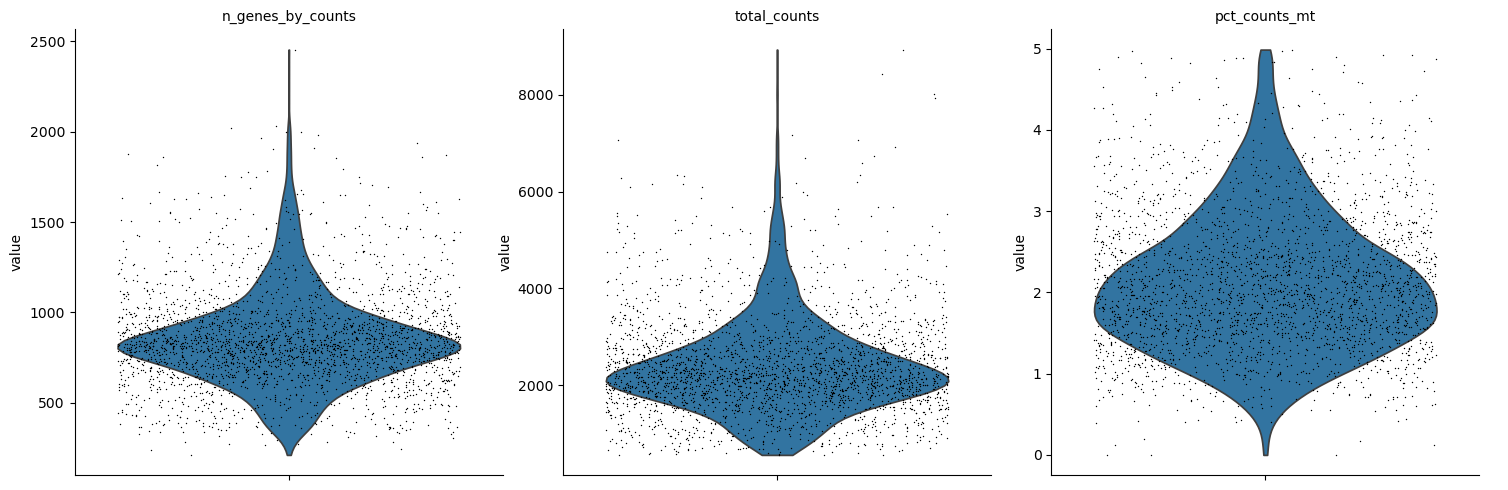

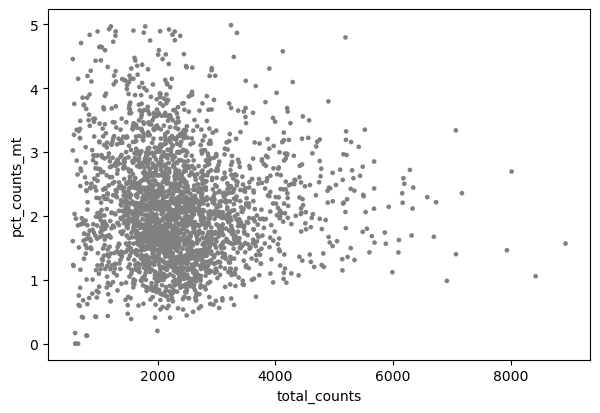

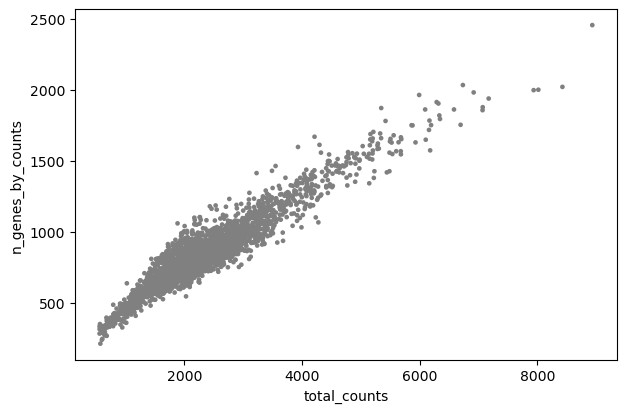

In [7]:
# Extended preprocessing pipeline
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Load data
adata = sc.datasets.pbmc3k()

# Calculate mitochondrial genes percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Quality control
# Filter cells based on number of genes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# Filter cells based on mitochondrial percentage
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Feature selection
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Optional: visualize QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# Plot relationships between QC metrics
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


## Principal Component Analysis (PCA)

PCA is a linear dimensionality reduction technique that transforms high-dimensional data into a new coordinate system. The first axis (principal component) captures the most variance in the data, and each subsequent component captures the maximum remaining variance while being orthogonal to previous components. These components are ordered by importance, measured by the amount of variance they explain.

Think of PCA as finding the "best" angles to photograph a complex 3D object to capture its most important features in 2D. When evaluating PCA results, we consider the explained variance ratio, cumulative explained variance, and scree plot analysis.

Here's how to implement and evaluate PCA:

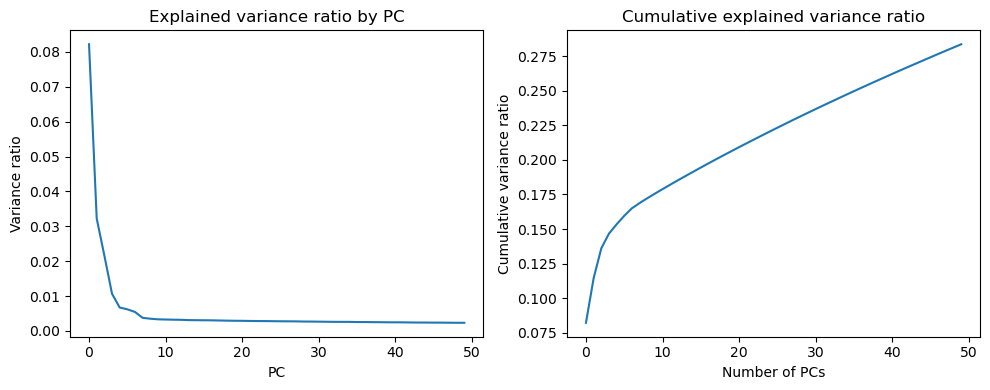

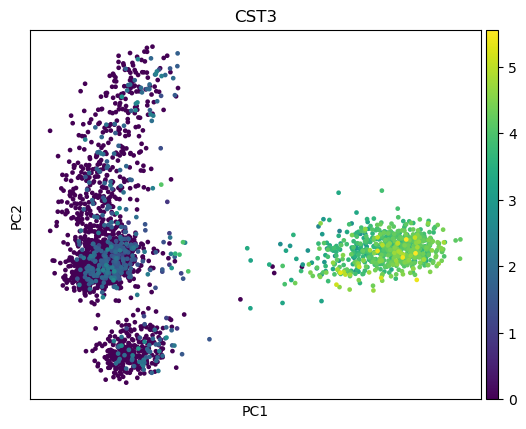

In [9]:
# Extended PCA implementation and evaluation
sc.tl.pca(adata, svd_solver='arpack')

# Plot explained variance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(adata.uns['pca']['variance_ratio'])
plt.xlabel('PC')
plt.ylabel('Variance ratio')
plt.title('Explained variance ratio by PC')

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(adata.uns['pca']['variance_ratio']))
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative explained variance ratio')
plt.tight_layout()
plt.show()

# Visualize first two PCA components
sc.pl.pca(adata, color='CST3')


## t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is a non-linear technique particularly good at preserving local structure. It works by converting high-dimensional Euclidean distances between points into conditional probabilities, creating a similar probability distribution in low-dimensional space, and minimizing the difference between these distributions using KL divergence.

t-SNE is stochastic, meaning results can vary between runs. It focuses on preserving local structure, but global structure is not necessarily preserved. The 'perplexity' parameter significantly affects the result, and choosing an appropriate value is crucial for meaningful visualizations.

Here's how to implement t-SNE with different perplexity values:

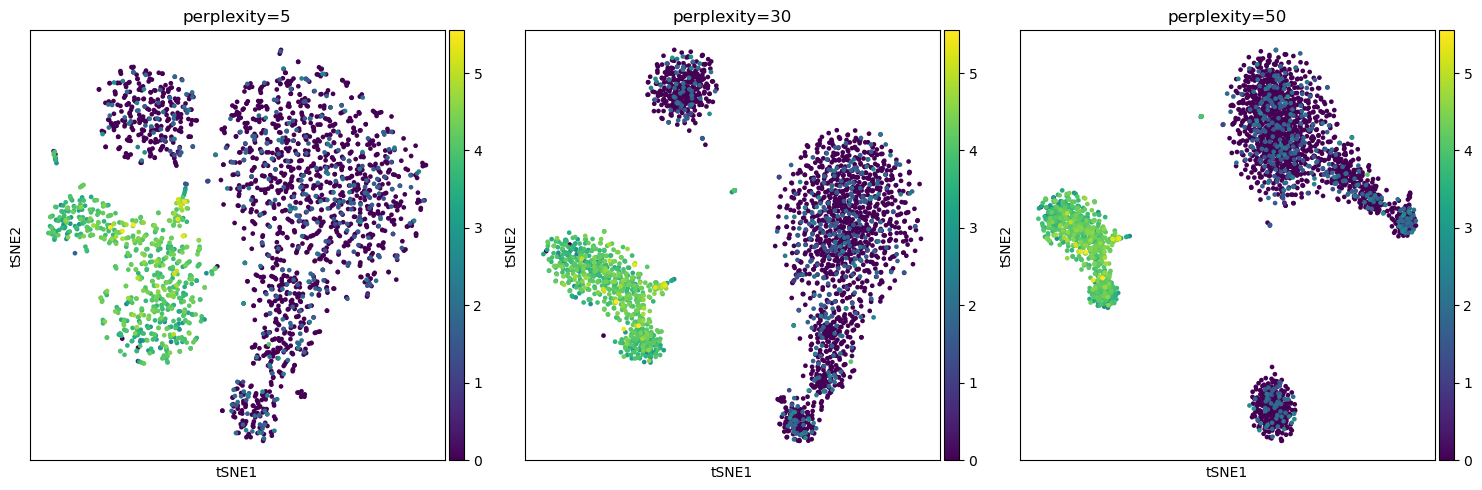

In [11]:
# Run t-SNE with different perplexity values
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, len(perplexities), figsize=(15, 5))

for idx, perp in enumerate(perplexities):
    # Create a copy of the data for each perplexity value
    adata_copy = adata.copy()
    # Run t-SNE
    sc.tl.tsne(adata_copy, use_rep='X_pca', perplexity=perp)
    # Plot
    sc.pl.tsne(adata_copy, color='CST3', 
               title=f'perplexity={perp}', 
               ax=axes[idx], 
               show=False)

plt.tight_layout()
plt.show()


## UMAP (Uniform Manifold Approximation and Projection)

UMAP is a more recent algorithm that offers several advantages over t-SNE, including better preservation of global structure, faster computation, and a strong theoretical foundation in manifold learning and topological data analysis.

UMAP works by creating a fuzzy topological representation of the high-dimensional data, finding a low-dimensional representation with a similar topological structure, and optimizing this representation using gradient descent. The algorithm is particularly effective at preserving both local and global structure while being computationally efficient.

Here's how to implement UMAP with different parameter settings:

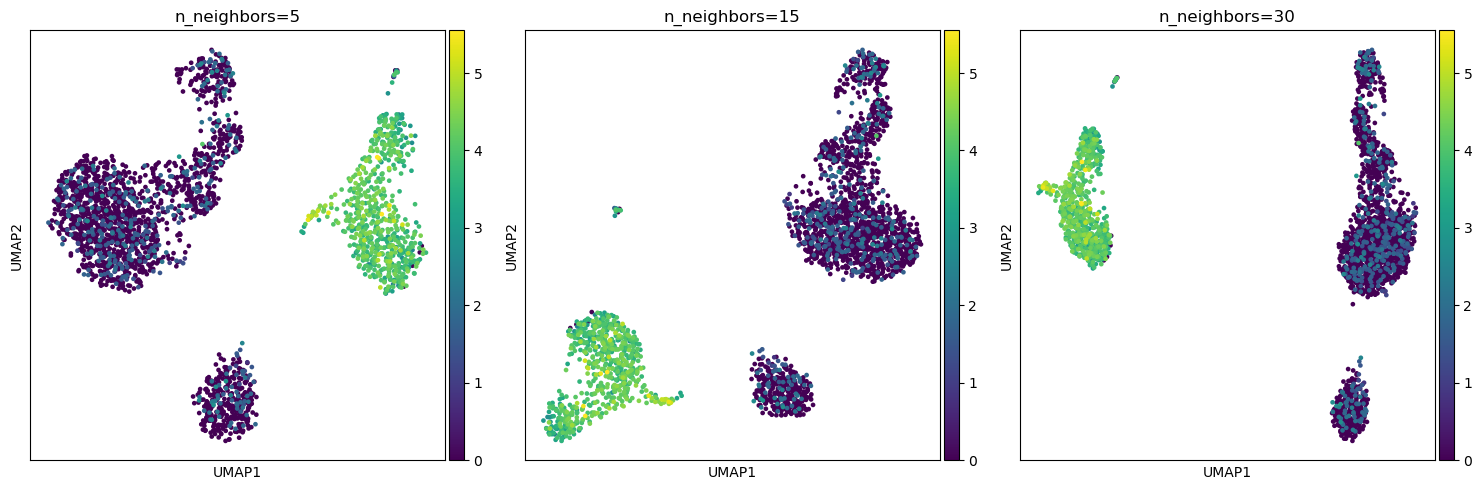

In [13]:
# Test different n_neighbors values for UMAP
n_neighbors_list = [5, 15, 30]
fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(15, 5))

for idx, n_neigh in enumerate(n_neighbors_list):
    # Create a copy of the data for each n_neighbors value
    adata_copy = adata.copy()
    # Calculate neighbors and run UMAP
    sc.pp.neighbors(adata_copy, n_neighbors=n_neigh, n_pcs=30)
    sc.tl.umap(adata_copy)
    # Plot
    sc.pl.umap(adata_copy, color='CST3',
               title=f'n_neighbors={n_neigh}',
               ax=axes[idx],
               show=False)

plt.tight_layout()
plt.show()

## Complete Analysis Pipeline

Here's a comprehensive pipeline that combines all these techniques:

/Users/srauschert/miniforge3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Number of cells: 2638
Number of genes: 2013


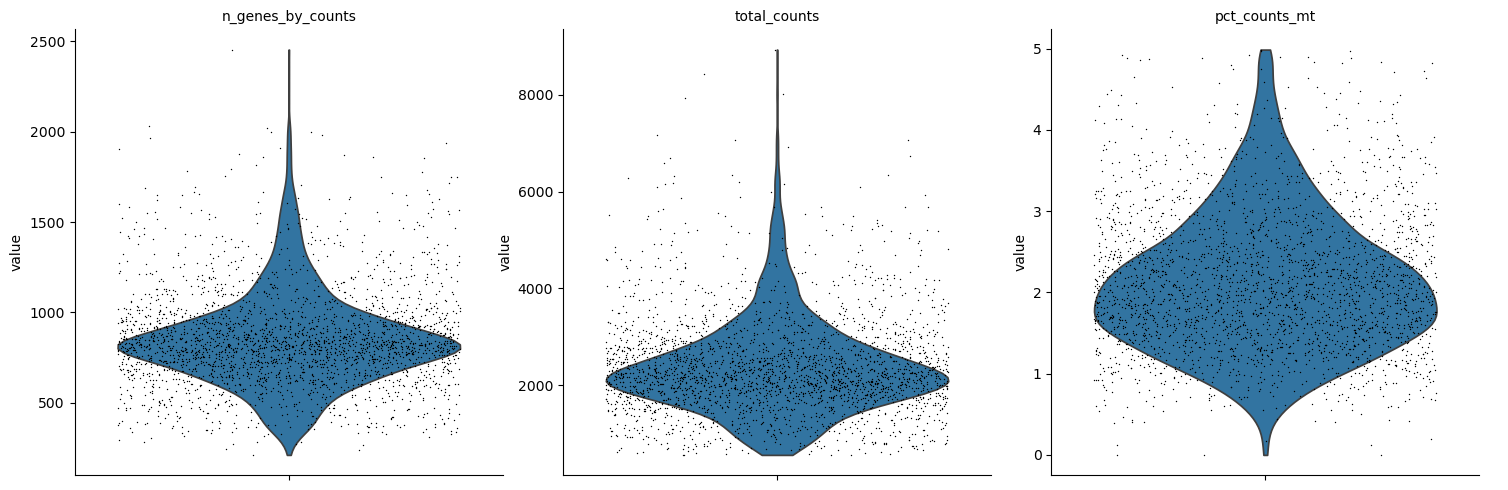

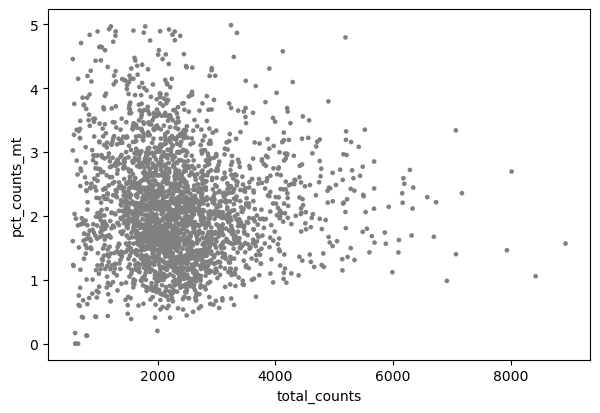

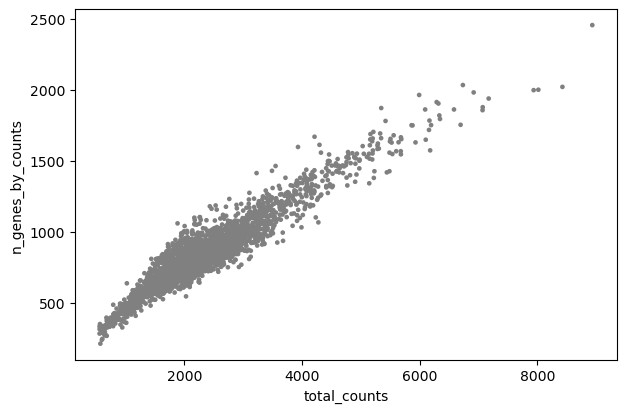

/Users/srauschert/miniforge3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


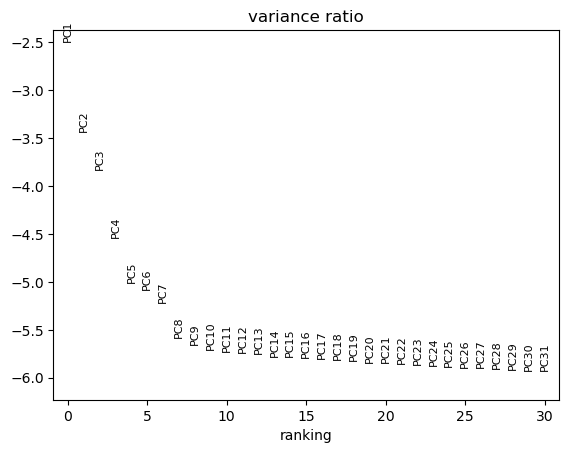

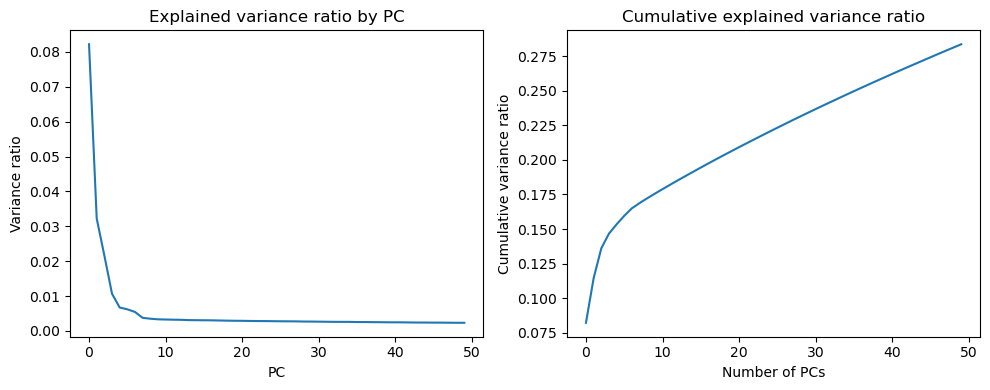

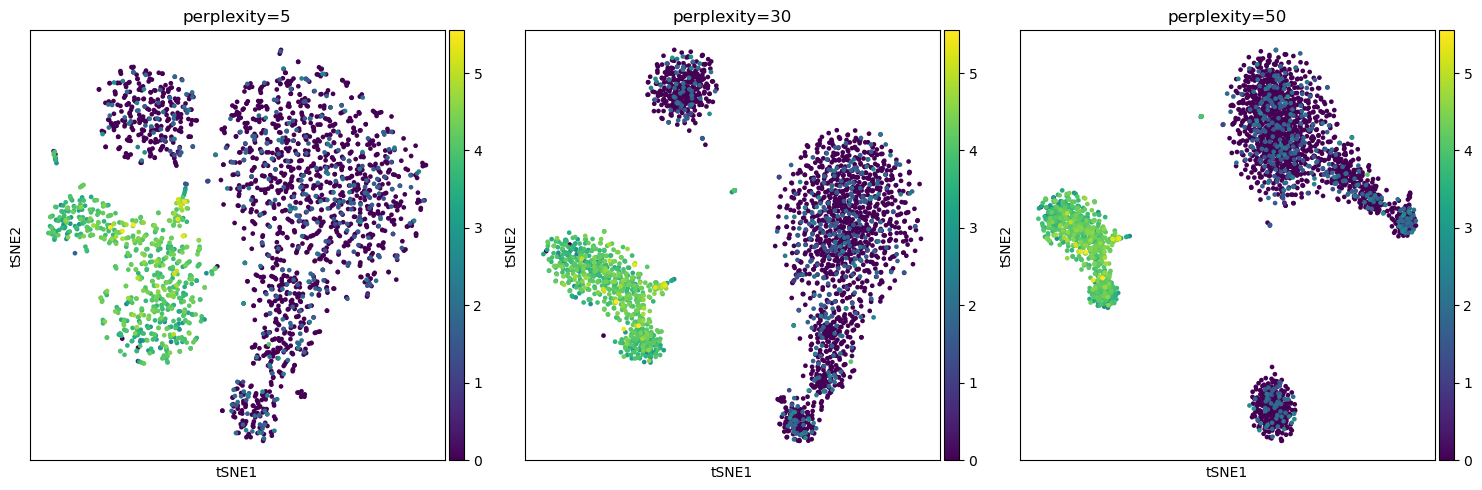

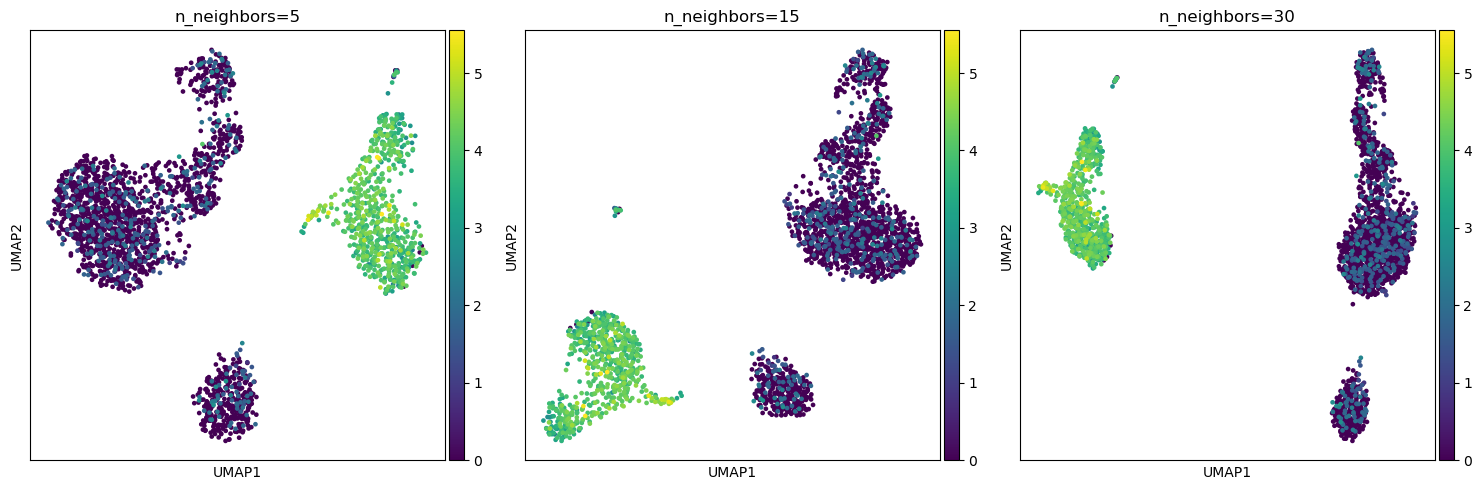

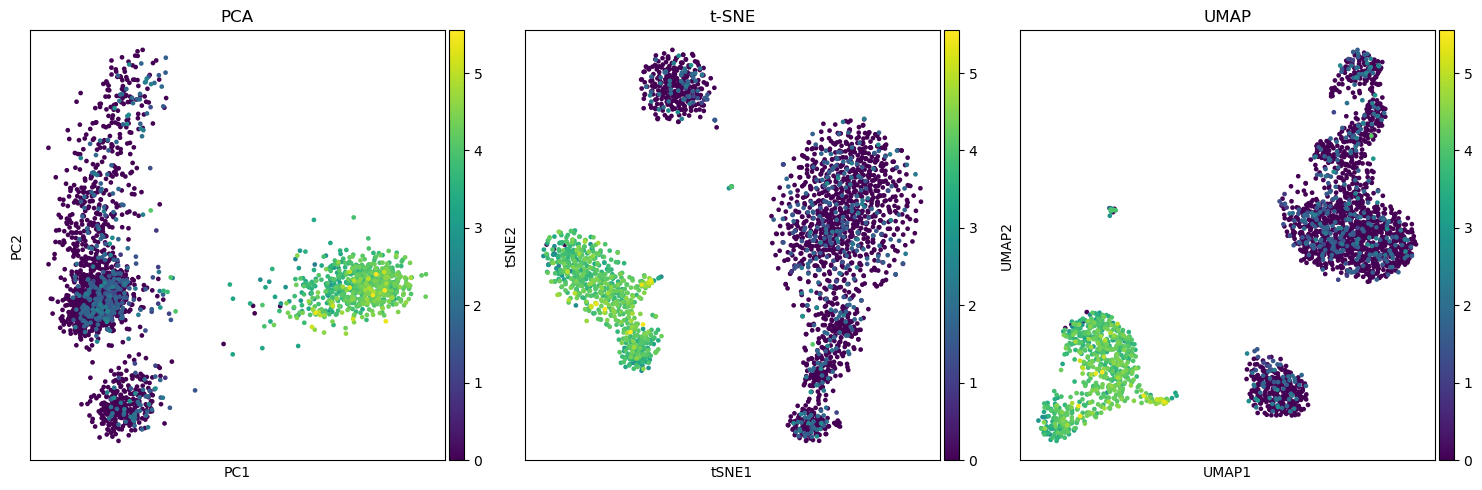


Summary Statistics:
Final number of cells: 2638
Final number of genes: 2013
Number of PCs used: 50


In [15]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Load data
adata = sc.datasets.pbmc3k()

# Calculate mitochondrial genes percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Quality control
# Filter cells based on number of genes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# Filter cells based on mitochondrial percentage
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Feature selection
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Visualize QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# Plot relationships between QC metrics
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

# Compare different numbers of PCs for variance explained
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(adata.uns['pca']['variance_ratio'])
plt.xlabel('PC')
plt.ylabel('Variance ratio')
plt.title('Explained variance ratio by PC')

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(adata.uns['pca']['variance_ratio']))
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative explained variance ratio')
plt.tight_layout()
plt.show()

# t-SNE with different perplexities
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, len(perplexities), figsize=(15, 5))

for idx, perp in enumerate(perplexities):
    # Create a copy of the data for each perplexity value
    adata_copy = adata.copy()
    # Run t-SNE
    sc.tl.tsne(adata_copy, use_rep='X_pca', perplexity=perp)
    # Plot
    sc.pl.tsne(adata_copy, color='CST3', 
               title=f'perplexity={perp}', 
               ax=axes[idx], 
               show=False)

plt.tight_layout()
plt.show()

# UMAP with different n_neighbors
n_neighbors_list = [5, 15, 30]
fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(15, 5))

for idx, n_neigh in enumerate(n_neighbors_list):
    # Create a copy of the data for each n_neighbors value
    adata_copy = adata.copy()
    # Calculate neighbors and run UMAP
    sc.pp.neighbors(adata_copy, n_neighbors=n_neigh, n_pcs=30)
    sc.tl.umap(adata_copy)
    # Plot
    sc.pl.umap(adata_copy, color='CST3',
               title=f'n_neighbors={n_neigh}',
               ax=axes[idx],
               show=False)

plt.tight_layout()
plt.show()

# Final combined visualization with default parameters
# Run t-SNE and UMAP with default parameters
sc.tl.tsne(adata, use_rep='X_pca')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

# Create combined plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sc.pl.pca(adata, color='CST3', ax=ax1, show=False)
ax1.set_title('PCA')

sc.pl.tsne(adata, color='CST3', ax=ax2, show=False)
ax2.set_title('t-SNE')

sc.pl.umap(adata, color='CST3', ax=ax3, show=False)
ax3.set_title('UMAP')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Final number of cells: {adata.n_obs}")
print(f"Final number of genes: {adata.n_vars}")
print(f"Number of PCs used: {adata.uns['pca']['variance_ratio'].shape[0]}")

## Practical Guidelines for Method Selection

Dataset size significantly influences method choice. For small datasets with fewer than 5000 cells, any method works well. Medium datasets (5000-50000 cells) benefit from PCA followed by UMAP. Large datasets exceeding 50000 cells may require PCA with UMAP using subsampling strategies.

Analysis goals also guide method selection. For global structure preservation, PCA or UMAP are preferred. Local structure preservation is better served by t-SNE or UMAP. When feature interpretation is crucial, PCA is the best choice. For visualization purposes, UMAP or t-SNE typically provide the most insightful results.

Computational resources must be considered. With limited resources, PCA is the most practical choice. Moderate resources allow for UMAP implementation. When abundant resources are available, any method can be used effectively.

The position in the analysis pipeline also matters. Initial exploration is best served by PCA, while feature selection typically relies on PCA results. Final visualization often benefits from UMAP or t-SNE, and downstream analysis can use either PCA or UMAP results depending on the specific requirements.

## Summary

Key takeaways from this exploration of dimensionality reduction techniques:

- PCA excels at fast, linear dimension reduction and is essential for initial data exploration
- t-SNE provides excellent visualization of local structure but requires careful parameter tuning
- UMAP offers a good balance of local and global structure preservation with better computational efficiency
- Proper preprocessing and parameter selection are crucial for meaningful results
- Different methods serve different purposes in the analysis pipeline